# Transfer Learning
<hr style="border:2px solid black">

## 1. Introduction

**What is transfer learning?**
- one of the most powerful ideas of deep learning
- taking knowledge learned from one task, and leveraging it on a similar but new task

**Why transfer learning?**
- big pre-trained models can be leveraged
- good accuracy with very little training (saves training time)
- allows training with very small training datasets

**When transfer learning for task-A$\rightarrow$task-B useful?**
- same input type for both tasks (is it also a numpy array?)
- big training data for task-A, but small training data for task-B
- low-level features of task-A useful for learning task-B

**How to implement transfer learning?**
1. take a pre-trained network, and remove its last layer(s)
2. replace the weights feeding into the last layer(s) with a new set of randomly intialized weights
3. Add new trainable layer(s) on top of the remaining layers
4. retrain the neural network on the new dataset; depending on dataset size:
    - `pre-training`: retrain only the weights of the newly added layer(s), freeze all the other layers
    - `fine tuning`: retrain the newly added layer(s) as well as some/all of the other layers

<hr style="border:2px solid black">

## 2. Pre-trained Model

### 2.1 Load packages

In [1]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# miscellaneous
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# deep learning stack
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image

In [2]:
# tensorflow and keras version
print(f'TensorFlow version: {tf.__version__}')
print(f'Keras version: {keras.__version__}')

TensorFlow version: 2.11.0
Keras version: 2.11.0


### 2.2 Load model

[`mobilenet_v2`](https://keras.io/api/applications/mobilenet/)

In [3]:
from tensorflow.keras.applications.mobilenet_v2 import (
    MobileNetV2,
    preprocess_input,
    decode_predictions
)

**instantiate model**

In [4]:
pretrained_model = MobileNetV2(
    weights='imagenet'
)

**model summary**

In [5]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

### 2.3 User-defined functions

In [6]:
def load_image(image_path):
    """
    loads an input image into PIL format of size 224 X 224
    """
    img = image.load_img(
        path=image_path,
        target_size=(224,224)
    )
    return img

In [7]:
def batch_image(loaded_image):
    """
    converts a loaded image to a batch
    """
    img_array = image.img_to_array(loaded_image)
    img_batch = np.array([img_array])
    
    return img_batch

In [8]:
def preprocess_image(batched_image):
    """
    preprocesses a batch image to make suitable for mobilenet_v2
    """
    processed_img = preprocess_input(batched_image)
    
    return processed_img

In [9]:
def show_preprocess_image(image_path):
    """
    shows loaded image given an image path, and
    preprocesses it to make suitable for mobilenet_v2
    """
    # load resized image
    loaded_img = load_image(image_path)
    
    # display image
    plt.figure(figsize=(3,3), dpi=100)
    plt.imshow(loaded_img)
    
    # create batched image
    batch_img = batch_image(loaded_img)
    
    # preprocess image
    processed_img = preprocess_image(batch_img)
    
    return processed_img

In [10]:
def image_class_prediction(model, preprocessed_image):
    """
    spits out the top-5 predictions of a given model with a proprocessed image
    """
    model_prediction = model.predict(preprocessed_image,verbose=0)
    decoded_prediction = decode_predictions(model_prediction,top=5)[0]
    data = {
        'image_class': [_[1] for _ in decoded_prediction],
        'probability': [_[2] for _ in decoded_prediction]
    }
    df = pd.DataFrame(data=data)
    return df

### 2.4 Model evaluation

**image classes**

In [11]:
CLASSES = os.listdir('../data/train_images')
CLASSES

['rose', 'tulip', 'sunflower']

**sunflower**

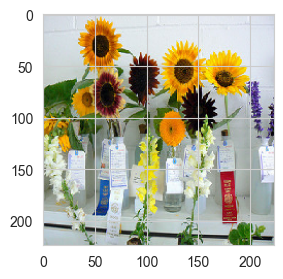

In [12]:
# show and preprocess image

sunflower_image = show_preprocess_image(
    '../data/test_images/sunflower/sunflower1.jpg'
)

In [13]:
# class prediction

image_class_prediction(
    pretrained_model,
    sunflower_image
)

,image_class,probability
0,vase,0.597295
1,picket_fence,0.280544
2,lotion,0.051335
3,perfume,0.015024
4,altar,0.006544


**tulip**

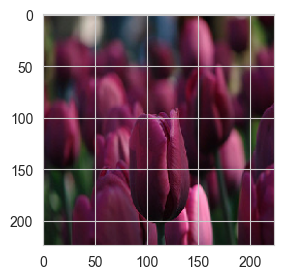

In [14]:
# show and preprocess image

tulip_image = show_preprocess_image(
    '../data/test_images/tulip/tulip1.jpg'
)

In [15]:
# class prediction

image_class_prediction(
    pretrained_model,
    tulip_image
)

,image_class,probability
0,picket_fence,0.375940
1,pot,0.098465
2,greenhouse,0.032084
3,bee,0.031355
4,coral_fungus,0.025839


**rose**

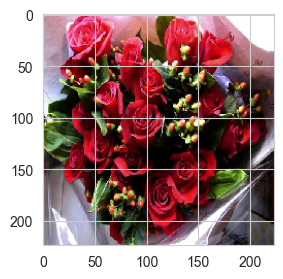

In [16]:
# show and preprocess image

rose_image = show_preprocess_image(
    '../data/test_images/rose/rose1.jpg'
)

In [17]:
# class prediction

image_class_prediction(
    pretrained_model,
    rose_image
)

,image_class,probability
0,pot,0.218442
1,vase,0.128060
2,groom,0.125314
3,bakery,0.073036
4,gown,0.061275


<hr style="border:2px solid black">

## 3. Transfer Learning Example

[**getting training images into keras**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [18]:
# instantiate image data generator

data_gen = image.ImageDataGenerator(
    # preprocessing function for all images
    preprocessing_function=preprocess_input
)

In [19]:
# generate batches of x and y arrays from directory

train_data_gen = data_gen.flow_from_directory(
        directory='../data/train_images',
        class_mode="categorical",
        classes=CLASSES,
        batch_size=300,
        target_size=(224,224)
)

Found 300 images belonging to 3 classes.


In [20]:
# load in all images at once

xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((300, 224, 224, 3), (300, 3))

### 3.1 Model Building 

**3.1.1 Select convolutional base with frozen weights**

In [21]:
# define base model

BASE_MODEL = MobileNetV2(
    weights='imagenet', 
    alpha=1.0,          # controls number of overall weights
    include_top=False,  # removal of final dense layers
    pooling='avg',      # average pooling to last convolutional layer's ouput
    input_shape=(224,224,3) # ignored if input tensor is provided
)

In [22]:
# freeze base model
BASE_MODEL.trainable = False

In [23]:
# base model summary
BASE_MODEL.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

**3.1.2 Add dense layers on top**

In [24]:
def BuildModel():
    '''
    complies a model by stacking dense layers on top of base model 
    '''
    # initialize the Sequential API to stack the layers
    model = keras.Sequential()
    
    # convolutional base 
    model.add(BASE_MODEL)
    
    # first dense layer
    model.add(
        keras.layers.Dense(
            units=160, 
            activation='relu'
        )
    )
    # dropout - do not let the neurons learn too much to prevent overfitting
    model.add(
        keras.layers.Dropout(
            rate=0.5
        )
    )
    # output layer with softmax activation function
    model.add(
        keras.layers.Dense(
            len(CLASSES),
            activation='softmax'
        )
    )
    # compile model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.categorical_crossentropy,
        metrics=[keras.metrics.categorical_accuracy]
    )

    return model

### 3.3 Model Training

**train model**

In [25]:
# instantiate model
model = BuildModel()

In [26]:
# early stopping (prevent overfitting)

stop_early = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10 #osilation dealing
)

In [27]:
model.fit(
    xtrain,
    ytrain,
    epochs=100,
    batch_size=20,#hyperparameter
    callbacks=[stop_early],
    validation_split=0.2
)

Epoch 1/100
12/12 [==============================] - 3s 170ms/step - loss: 0.9069 - categorical_accuracy: 0.6000 - val_loss: 0.3630 - val_categorical_accuracy: 0.9000
Epoch 2/100
12/12 [==============================] - 2s 132ms/step - loss: 0.3096 - categorical_accuracy: 0.8833 - val_loss: 0.2362 - val_categorical_accuracy: 0.9333
Epoch 3/100
12/12 [==============================] - 2s 136ms/step - loss: 0.2451 - categorical_accuracy: 0.9292 - val_loss: 0.3706 - val_categorical_accuracy: 0.9167
Epoch 4/100
12/12 [==============================] - 2s 136ms/step - loss: 0.1042 - categorical_accuracy: 0.9667 - val_loss: 0.2062 - val_categorical_accuracy: 0.9167
Epoch 5/100
12/12 [==============================] - 2s 135ms/step - loss: 0.0767 - categorical_accuracy: 0.9792 - val_loss: 0.2429 - val_categorical_accuracy: 0.9167
Epoch 6/100
12/12 [==============================] - 2s 137ms/step - loss: 0.0465 - categorical_accuracy: 0.9917 - val_loss: 0.2217 - val_categorical_accuracy: 0.916

**training history: losses and epoch numbers**

In [28]:
# losses in the training history
losses = pd.DataFrame(model.history.history)
# training loss
loss = losses['loss'].values 
# validation loss
val_loss = losses['val_loss'].values

# epoch number
epoch = losses.index.values + np.ones_like(losses.index.values)

**plot training history**

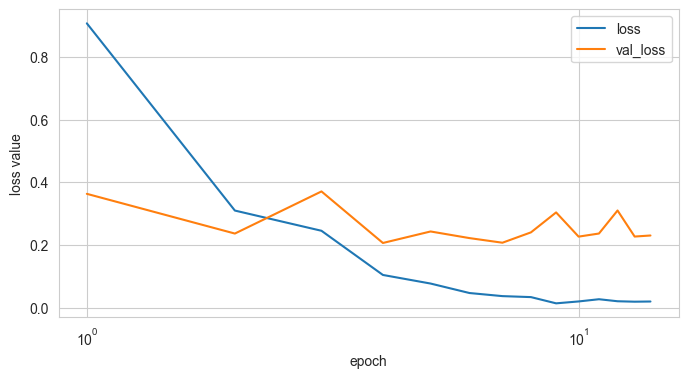

In [29]:
# plot losses against epoch number in log-scale
plt.figure(figsize=(8,4),dpi=100)
plt.semilogx(epoch, loss, linewidth=1.5, label='loss')
plt.semilogx(epoch, val_loss, linewidth=1.5, label='val_loss')

plt.xlabel('epoch',fontsize=10)
plt.ylabel('loss value',fontsize=10)
plt.legend(loc=1,fontsize=10);

### 3.4 Model Evaluation

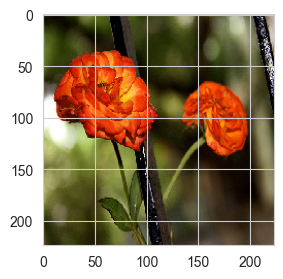

In [30]:
# show and preprocess image
test_image = show_preprocess_image('../data/test_images/rose/rose0.jpg')

In [31]:
def image_predict(preprocessed_image, model):
    """
    returns class probabilities for a given image,
    based on the model obtained via transfer learning 
    """
    probabilities = model.predict(
        preprocessed_image,
        verbose=0
    )
    probabilities = np.round(probabilities,6)[0]
    class_probabilities = dict(zip(CLASSES,probabilities))
    
    return class_probabilities

In [32]:
# predict image class
image_predict(test_image, model)

{'rose': 0.873137, 'tulip': 0.12621, 'sunflower': 0.000653}

In [33]:
# generate batches of x and y arrays from directory

test_data_gen = data_gen.flow_from_directory(
        directory='../data/test_images',
        class_mode="categorical",
        classes=CLASSES,
        target_size=(224, 224)
)

Found 30 images belonging to 3 classes.


In [34]:
# load in all images at once
xtest, ytest = next(test_data_gen)
xtest.shape, ytest.shape

((30, 224, 224, 3), (30, 3))

In [35]:
def transfer_learning_prediction(model, x, y):
    """
    returns dataframe with class probabilities and true class label 
    """
    # prediction dataframe along with true class
    df_pred = pd.DataFrame(
        columns=CLASSES,
        data=np.round(model.predict(x,verbose=0),6)
    )
    # convert vectorized classes into strings
    df_pred['class'] = \
    [''.join([i*j for (i,j) in zip(CLASSES,vector)]) for vector in y.astype(int)]
    # getting from the vector the name of the class
    return df_pred

In [36]:
# model predictions

test_prediction = transfer_learning_prediction(
    model,
    xtest,
    ytest
)

test_prediction

,rose,tulip,sunflower,class
0,0.000365,0.006640,0.992995,sunflower
1,0.966058,0.033625,0.000318,rose
2,0.000297,0.998218,0.001484,tulip
3,0.000003,0.000111,0.999886,sunflower
4,0.000048,0.011141,0.988811,sunflower
5,0.962868,0.037130,0.000002,tulip
6,0.009523,0.990472,0.000005,tulip
7,0.000071,0.001648,0.998281,sunflower
8,0.005934,0.993388,0.000678,tulip
9,0.000199,0.999787,0.000015,tulip


In [37]:
def accuracy_score(model,x,y):
    """
    This function spits out multi-class accuracy
    """
    grouped_df = transfer_learning_prediction(
        model, x, y
    ).groupby('class').sum()
    
    grouped_df.sort_index(axis=1,inplace=True)
    #trace = take sum of diagonal
    accuracy_score = np.trace(grouped_df)/np.array(grouped_df).sum()
    accuracy_score = round(accuracy_score,6)
    
    return accuracy_score

In [38]:
group_df = transfer_learning_prediction(
        model, xtest, ytest
        ).groupby("class").sum()
group_df

,rose,tulip,sunflower
class,,,
rose,9.044318,0.191238,0.764444
sunflower,0.040682,0.168727,9.790590
tulip,1.048630,8.939520,0.011851


In [39]:
group_df.sort_index(axis = 1, inplace = True)

In [40]:
group_df

,rose,sunflower,tulip
class,,,
rose,9.044318,0.764444,0.191238
sunflower,0.040682,9.790590,0.168727
tulip,1.048630,0.011851,8.939520


In [41]:
np.trace(group_df)

27.774427

In [42]:
np.array(group_df).sum()

30.000002

In [43]:
accuracy_score(model, xtest, ytest)

0.925814

In [44]:
accuracy_score(model, xtrain, ytrain)

0.978784

<hr style="border:2px solid black">

## References

1. [Transfer Learning, Andrew Ng](https://www.youtube.com/watch?v=yofjFQddwHE)

2. [Introduction to the Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)

3. [Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization
](https://jmlr.org/papers/v18/16-558.html)